In [1]:
import earthaccess
import xarray as xr
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
import re
import matplotlib.pyplot as plt

# -------------------------------------------
# 1️⃣ Authenticate
# -------------------------------------------
auth = earthaccess.login(strategy="interactive")

# -------------------------------------------
# 2️⃣ Search PACE OCI L3 8D Files
# -------------------------------------------
bbox = (-77.0, 34.0, -65.0, 45.0)
date_range = ("2024-03-01", "2025-07-01")

chl_results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    bounding_box=bbox,
    temporal=date_range,
    granule_name="*.8D.*.4km.*"
)
rrs_results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS",
    bounding_box=bbox,
    temporal=date_range,
    granule_name="*.8D.*.4km.*"
)

# -------------------------------------------
# 3️⃣ Sort & Open Files for Streaming
# -------------------------------------------
chl_files = sorted(chl_results, key=lambda r: r.data_links()[0].split('/')[-1])
rrs_files = sorted(rrs_results, key=lambda r: r.data_links()[0].split('/')[-1])

chl_opened = earthaccess.open(chl_files)
rrs_opened = earthaccess.open(rrs_files)

# -------------------------------------------
# 4️⃣ Extract Dates from Filenames
# -------------------------------------------
def extract_start_date_from_result(result):
    filename = result.data_links()[0].split('/')[-1]
    match = re.search(r'\.(\d{8})_(\d{8})\.', filename)
    if match:
        return pd.to_datetime(match.group(1), format='%Y%m%d')
    else:
        return pd.NaT

chl_dates = [extract_start_date_from_result(r) for r in chl_files]

# -------------------------------------------
# 5️⃣ Functions for AVW / Brightness
# -------------------------------------------
def calc_avw(wavelengths, rrs):
    return np.sum(rrs) / np.sum(rrs/wavelengths)

def calc_brightness(rrs, wavelengths):
    return trapezoid(rrs, wavelengths, axis=-1)

# -------------------------------------------
# 6️⃣ Chlorophyll Bins
# -------------------------------------------
chlor_bins = [
    (0.0075, 0.0125),
    (0.075, 0.125),
    (0.475, 0.525),
    (0.975, 1.025),
    (4.975, 5.025),
    (9.75, 10.25),
    (24.75, 25.25)
]
bins_labels = [f"{lo}-{hi}" for lo, hi in chlor_bins]


QUEUEING TASKS | :   0%|          | 0/53 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/53 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/53 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/53 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/53 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/53 [00:00<?, ?it/s]

In [2]:
## -------------------------------------------
## 6. Main Processing Loop (Optimized Version)
## -------------------------------------------
print("\nStarting processing loop (Optimized Version)...")
lat_bounds = [34.0, 45.0]
lon_bounds = [-77.0, -65.0]

# Initialize a dictionary to store all results
results = {label: {'dates': [], 'avw': [], 'brightness': [], 'mean_rrs': []} for label in bins_labels}

# Get wavelengths once and create masks for calculation/plotting
with xr.open_dataset(rrs_opened[0]) as first_rrs_ds:
    wavelengths_full = first_rrs_ds.wavelength.values
vis_range_mask = (wavelengths_full >= 400) & (wavelengths_full <= 700)
wavelengths_vis = wavelengths_full[vis_range_mask]
bin_label_index = pd.Index(bins_labels, name='bin')

# Loop through each time step
for i, (chl_file, rrs_file, date) in enumerate(zip(chl_opened, rrs_opened, chl_dates)):
    print(f"Processing {date.strftime('%Y-%m-%d')} ({i+1}/{len(chl_dates)})...")
    
    with xr.open_dataset(chl_file) as chl_ds, xr.open_dataset(rrs_file) as rrs_ds:
        chlor_a_data = chl_ds.sel(lat=slice(lat_bounds[1], lat_bounds[0]), lon=slice(lon_bounds[0], lon_bounds[1]))['chlor_a']
        rrs_sub = rrs_ds.sel(lat=slice(lat_bounds[1], lat_bounds[0]), lon=slice(lon_bounds[0], lon_bounds[1]))

        # --- Vectorized Optimization ---
        # 1. Create a stack of boolean masks for all bins at once
        mask_list = [(chlor_a_data >= lo) & (chlor_a_data <= hi) for lo, hi in chlor_bins]
        mask_stack = xr.concat(mask_list, dim=bin_label_index)

        # 2. Apply all masks and calculate the mean for all bins in one operation
        mean_spectra_per_bin = rrs_sub['Rrs'].where(mask_stack).mean(dim=['lat', 'lon'], skipna=True)
        # --- End of Optimization ---

        # Loop through the pre-calculated results (this part is fast)
        for label in mean_spectra_per_bin.bin.values:
            mean_rrs_spectrum = mean_spectra_per_bin.sel(bin=label)
            if mean_rrs_spectrum.isnull().all(): continue

            rrs_vis = mean_rrs_spectrum.values[vis_range_mask]
            avw = calc_avw(wavelengths_vis, rrs_vis)
            brightness = calc_brightness(rrs_vis, wavelengths_vis)

            if avw < 400: avw, brightness = np.nan, np.nan
            
            results[label]['dates'].append(date)
            results[label]['avw'].append(avw)
            results[label]['brightness'].append(brightness)
            results[label]['mean_rrs'].append(mean_rrs_spectrum)

print("Processing loop complete.")



Starting processing loop (Optimized Version)...
Processing 2024-03-05 (1/53)...
Processing 2024-03-13 (2/53)...
Processing 2024-03-21 (3/53)...
Processing 2024-03-29 (4/53)...
Processing 2024-04-06 (5/53)...
Processing 2024-04-14 (6/53)...
Processing 2024-04-22 (7/53)...
Processing 2024-04-30 (8/53)...
Processing 2024-05-08 (9/53)...
Processing 2024-05-16 (10/53)...
Processing 2024-05-24 (11/53)...
Processing 2024-06-01 (12/53)...
Processing 2024-06-09 (13/53)...
Processing 2024-06-17 (14/53)...
Processing 2024-06-25 (15/53)...
Processing 2024-07-03 (16/53)...
Processing 2024-07-11 (17/53)...
Processing 2024-07-19 (18/53)...
Processing 2024-07-27 (19/53)...
Processing 2024-08-04 (20/53)...
Processing 2024-08-12 (21/53)...
Processing 2024-08-20 (22/53)...
Processing 2024-08-28 (23/53)...
Processing 2024-09-05 (24/53)...
Processing 2024-09-13 (25/53)...
Processing 2024-09-21 (26/53)...
Processing 2024-09-29 (27/53)...
Processing 2024-10-07 (28/53)...
Processing 2024-10-15 (29/53)...
Pro

In [24]:
import pandas as pd

# This code should run AFTER 'results' and 'wavelengths_full' are available.

print("\nExporting results to CSV with expanded Rrs columns...")

# 1. Create descriptive column names for each wavelength
# This will create headers like 'Rrs_400.0', 'Rrs_412.5', etc.
rrs_column_names = [f'{wl:.1f}' for wl in wavelengths_full]

# 2. Prepare a list to hold the data for the DataFrame
data_for_dataframe = []

# 3. Loop through your results to flatten the data
for bin_label, data in results.items():
    # Iterate through each recorded data point in the bin
    for i in range(len(data['dates'])):
        
        # A. Start with the basic metadata for the row
        row = {
            'bin_label': bin_label,
            'date': data['dates'][i],
            'avw': data['avw'][i],
            'brightness': data['brightness'][i],
        }
        
        # B. Get the Rrs values for this specific spectrum
        spectrum_values = data['mean_rrs'][i].values
        
        # C. Create a dictionary mapping each wavelength column to its value
        rrs_data_dict = dict(zip(rrs_column_names, spectrum_values))
        
        # D. Merge the metadata with the Rrs data to form a complete row
        row.update(rrs_data_dict)
        
        data_for_dataframe.append(row)

# 4. Create a pandas DataFrame and save it to a CSV file
if data_for_dataframe:
    df = pd.DataFrame(data_for_dataframe)
    
    # Define your new output filename
    output_filename = 'ocean_color_results_expanded.csv'
    
    # Save the DataFrame to CSV
    df.to_csv(output_filename, index=False)
    
    print(f"✅ Successfully saved expanded data to '{output_filename}'")
else:
    print("No data was found to export.")


Exporting results to CSV with expanded Rrs columns...
✅ Successfully saved expanded data to 'ocean_color_results_expanded.csv'


In [19]:

## -------------------------------------------
## 7. Calculate Overall Mean Spectra
## -------------------------------------------
print("\nCalculating overall mean spectra for each bin...")
overall_mean_spectra = {}
for label, data in results.items():
    if data['mean_rrs']: # Check if there are any spectra to average
        all_spectra_for_bin = xr.concat(data['mean_rrs'], dim='time')
        overall_mean_spectra[label] = all_spectra_for_bin.mean(dim='time', skipna=True)
print("Calculation of overall means complete.")

# --- 1. Calculate the Overall Mean AVW for Each Bin ---
print("\nCalculating overall mean AVW for each bin...")
overall_mean_avw = {}
for label, data in results.items():
    if data.get('avw'):  # Check if 'avw' list exists and is not empty
        overall_mean_avw[label] = np.mean(data['avw'])
print("Calculation of mean AVW complete.")


# --- 2. Calculate the Difference and Add it to the Results Dict ---
print("\nCalculating AVW difference from the mean for each data point...")
for label, data in results.items():
    # Check if there's data and a corresponding mean to use
    if data.get('avw') and label in overall_mean_avw:
        
        # Get the pre-calculated mean AVW for this bin
        mean_avw = overall_mean_avw[label]
        
        # Use a list comprehension to calculate the difference for each point
        avw_differences = [individual_avw - mean_avw for individual_avw in data['avw']]
        
        # Add the new list of differences back into the results dictionary
        results[label]['avw_diff'] = avw_differences
        
print("AVW difference calculation complete.")



Calculating overall mean spectra for each bin...
Calculation of overall means complete.

Calculating overall mean AVW for each bin...
Calculation of mean AVW complete.

Calculating AVW difference from the mean for each data point...
AVW difference calculation complete.


In [4]:
def plot_time_series(results_dict):
    print("\nGenerating time-series plots...")
    for label, data in results_dict.items():
        if not data['dates']: continue
        
        fig, ax1 = plt.subplots(figsize=(11, 5))
        fig.suptitle(f"Time Series for Chlorophyll Bin: {label}", fontsize=16)
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel('AVW (nm)', color='teal')
        ax1.plot(data['dates'], data['avw'], 'o-', color='teal')
        ax1.tick_params(axis='y', labelcolor='teal')
        ax1.grid(True, linestyle='--', alpha=0.6)
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Rrs Brightness ($sr^{-1}$)', color='coral')
        ax2.plot(data['dates'], data['brightness'], 'o-', color='coral')
        ax2.tick_params(axis='y', labelcolor='coral')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def plot_spectral_comparison(selected_date_str, selected_bin_label):
    target_date = pd.to_datetime(selected_date_str)
    
    try:
        date_idx = results[selected_bin_label]['dates'].index(target_date)
        single_spectrum = results[selected_bin_label]['mean_rrs'][date_idx]
    except (ValueError, KeyError):
        print(f"Error: Could not find data for {selected_date_str} in bin '{selected_bin_label}'.")
        return
        
    overall_mean = overall_mean_spectra.get(selected_bin_label)
    if overall_mean is None: return

    diff = overall_mean - single_spectrum

    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths_full, diff, label=f"Mean Spectrum for {target_date.strftime('%Y-%m-%d')}", lw=2)
    #plt.plot(wavelengths_full, single_spectrum, label=f"Mean Spectrum for {target_date.strftime('%Y-%m-%d')}", lw=2)
    #plt.plot(wavelengths_full, overall_mean, label="Overall Mean for Bin", linestyle='--', lw=2)
    #plt.title(f"Spectral Comparison for Chlorophyll Bin: {selected_bin_label}")
    plt.title(f"Spectral Difference for Chlorophyll Bin: {selected_bin_label}")
    plt.xlabel("Wavelength (nm)"), plt.ylabel("Mean Rrs ($sr^{-1}$)")
    plt.grid(True, alpha=0.6), plt.xlim(400, 700), plt.legend(), plt.show()

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np

def plot_all_diff_spectra(results_dict, overall_mean_spectra, wavelengths):
    """
    Generates a series of plots, one for each chlorophyll bin.
    Each plot shows the difference spectra for all available dates,
    color-coded by date.

    Args:
        results_dict (dict): The main dictionary containing your processed data,
                             including dates and mean_rrs spectra for each bin.
        overall_mean_spectra (dict): A dictionary with the overall mean spectrum
                                     for each chlorophyll bin.
        wavelengths (list or np.array): The wavelength values for the x-axis.
    """
    print("\nGenerating spectral difference plots...")

    # Loop through each chlorophyll bin in your results
    for label, data in results_dict.items():
        if not data['dates']:  # Skip if a bin has no data
            continue

        overall_mean = overall_mean_spectra.get(label)
        if overall_mean is None:
            print(f"Warning: No overall mean spectrum found for bin '{label}'. Skipping.")
            continue

        fig, ax = plt.subplots(figsize=(11, 6))

        # --- 1. Set up the Date-to-Color Mapping ---
        dates = data['dates']
        date_nums = mdates.date2num(dates) # Convert dates to numbers for mapping

        # Create a normalizer to map the date numbers to the range [0, 1]
        norm = plt.Normalize(vmin=np.min(date_nums), vmax=np.max(date_nums))
        # Choose a colormap (e.g., 'viridis', 'plasma', 'cividis', 'jet')
        cmap = cm.viridis

        # --- 2. Loop Through and Plot Each Spectrum ---
        for i, date in enumerate(dates):
            # Calculate the difference from the overall mean
            single_spectrum = data['mean_rrs'][i]
            diff_spectrum = overall_mean - single_spectrum

            # Get the color for this date from the colormap
            color = cmap(norm(date_nums[i]))

            # Plot the difference spectrum
            ax.plot(wavelengths, diff_spectrum, color=color, alpha=0.85)

        # --- 3. Add Final Plot Elements ---
        # Add a horizontal line at y=0 for reference
        ax.axhline(0, color='black', linestyle='--', lw=1.5)

        # Create a scalar mappable for the colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Date', rotation=270, labelpad=20, fontsize=12)

        # Format the colorbar ticks to be readable dates
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        cbar.ax.yaxis.set_major_locator(locator)
        cbar.ax.yaxis.set_major_formatter(formatter)

        ax.set_title(f"Spectral Difference from Mean for Chlorophyll Bin: {label}", fontsize=16)
        ax.set_xlabel("Wavelength (nm)", fontsize=12)
        ax.set_ylabel("Difference in Rrs ($sr^{-1}$)", fontsize=12)
        ax.set_xlim(400, 700)
        ax.grid(True, linestyle=':', alpha=0.7)

        plt.tight_layout()
        plt.show()


Generating spectral difference plots...


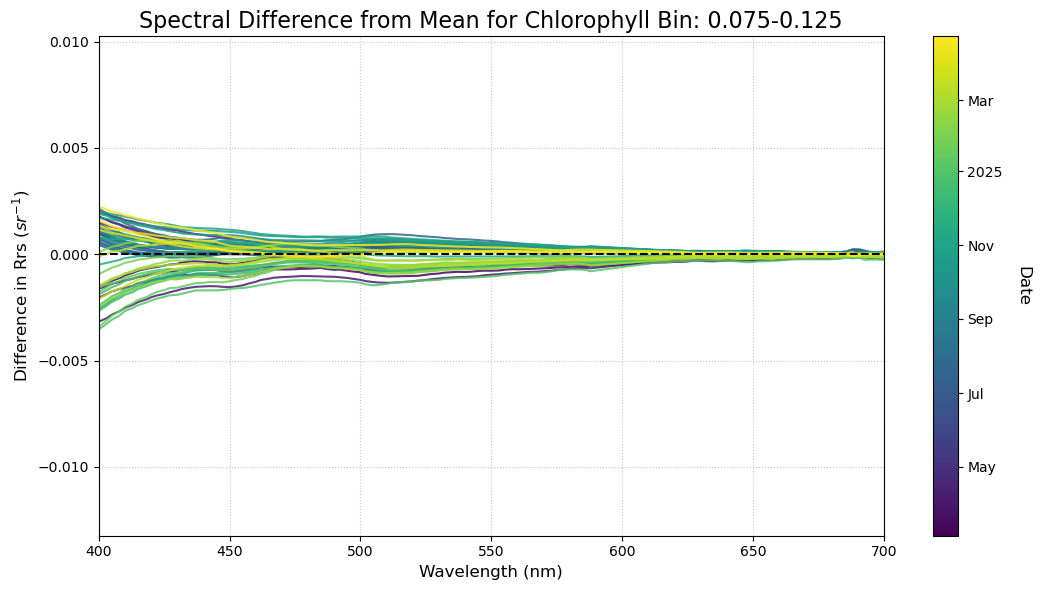

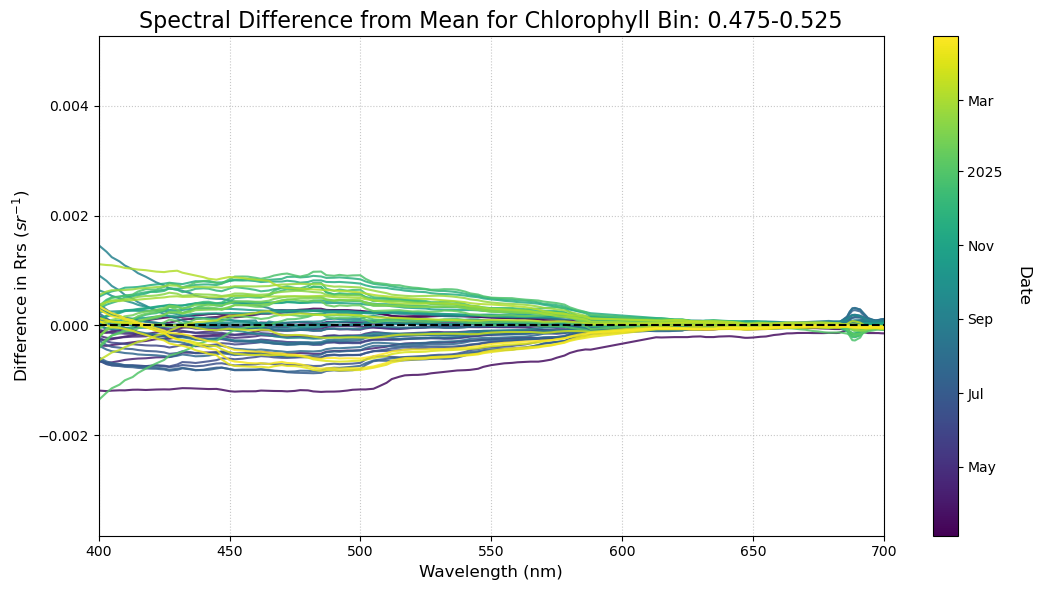

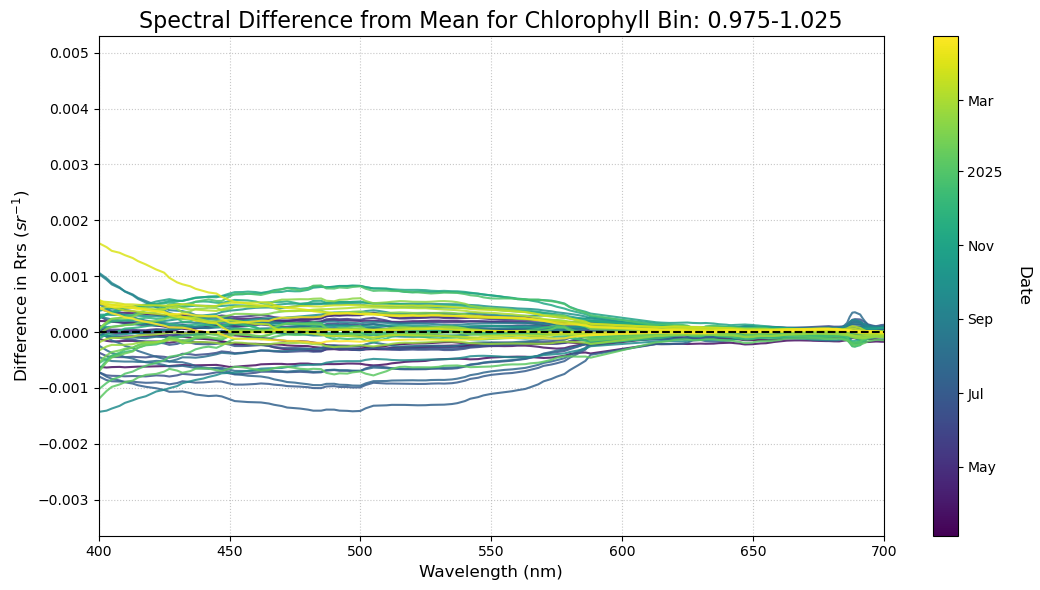

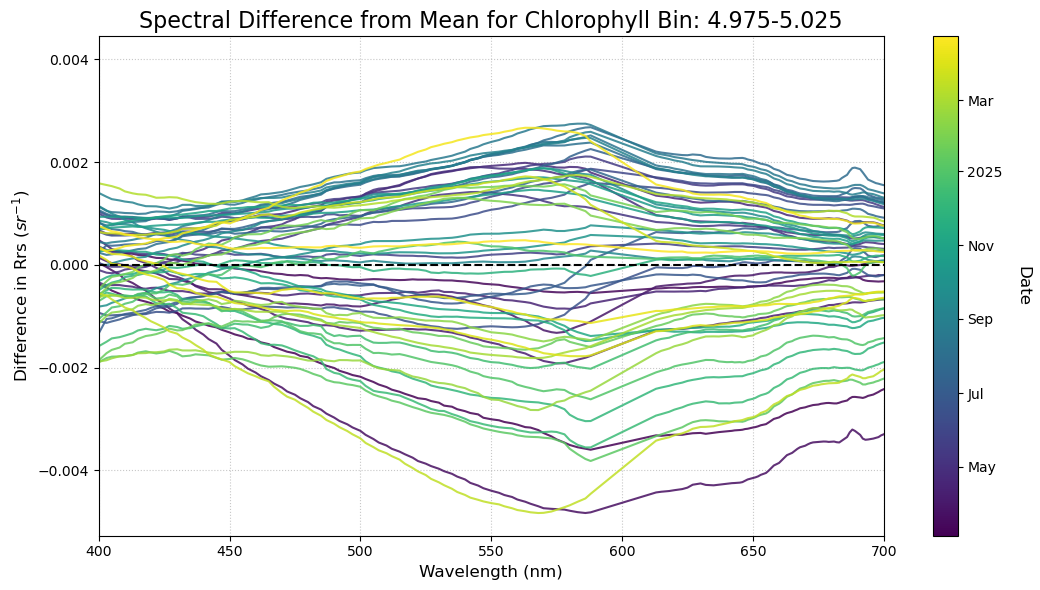

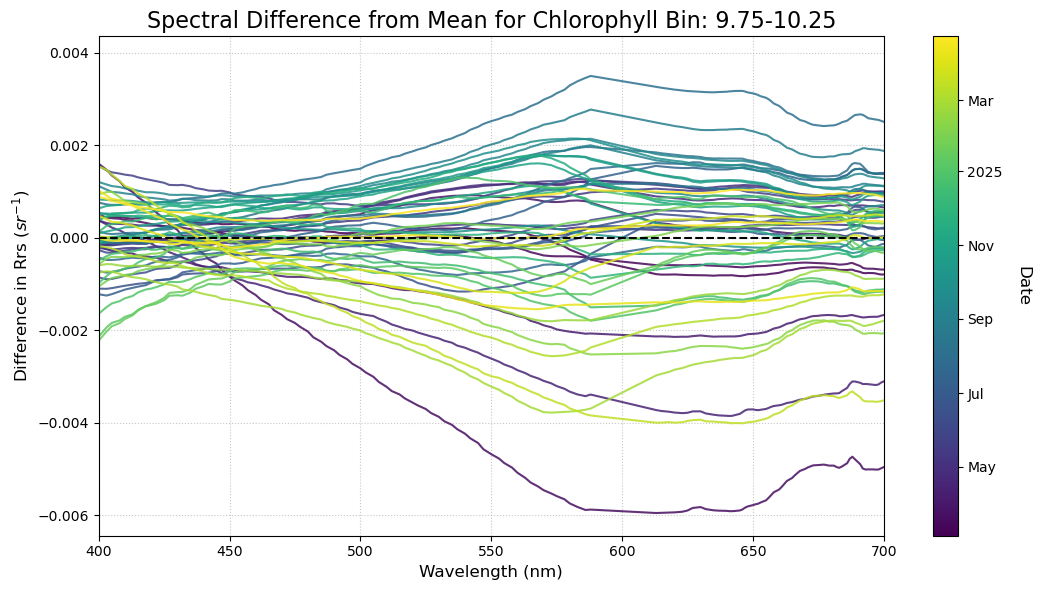

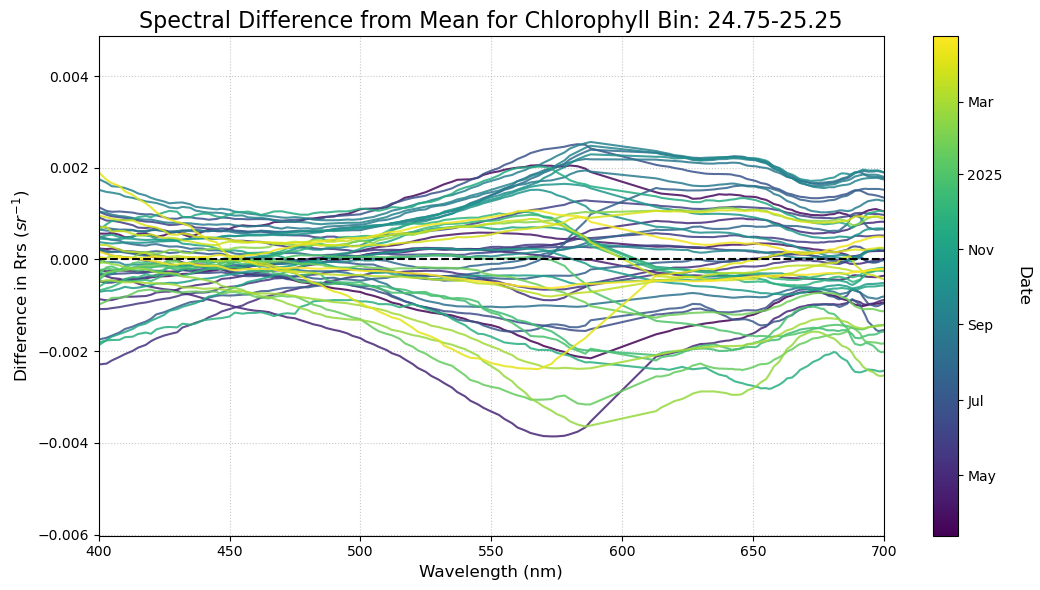

In [13]:
#  '0.075-0.125'
#  '0.475-0.525'
#  '0.975-1.025'
#  '4.975-5.025'
#  '9.75-10.25'
#  '24.75-25.25'

selected_bin_label = "0.1-0.3"

plot_all_spectral_differences(selected_bin_label)


In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_diff_spectra_by_avw(results_dict, overall_mean_spectra, wavelengths):
    """
    Generates a series of plots, one for each chlorophyll bin.
    Each plot shows the difference spectra for all available dates,
    color-coded by Apparent Visible Wavelength (AVW).

    Args:
        results_dict (dict): The main dictionary containing your processed data,
                             including avw and mean_rrs spectra for each bin.
        overall_mean_spectra (dict): A dictionary with the overall mean spectrum
                                     for each chlorophyll bin.
        wavelengths (list or np.array): The wavelength values for the x-axis.
    """
    print("\nGenerating spectral difference plots (color-coded by AVW)...")

    # Loop through each chlorophyll bin
    for label, data in results_dict.items():
        if not data['avw']:  # Check for AVW data
            continue

        overall_mean = overall_mean_spectra.get(label)
        if overall_mean is None:
            print(f"Warning: No overall mean spectrum found for bin '{label}'. Skipping.")
            continue

        fig, ax = plt.subplots(figsize=(11, 6))

        # --- 1. Set up the AVW-to-Color Mapping ---
        avw_values = data['avw_diff'] # Use AVW values instead of dates
        
        # Create a normalizer to map the AVW values to the range [0, 1]
        norm = plt.Normalize(vmin=np.min(avw_values), vmax=np.max(avw_values))
        
        # 'cividis', 'plasma', or 'viridis' are great choices for this type of data
        cmap = cm.cividis

        # --- 2. Loop Through and Plot Each Spectrum ---
        # Iterate using the avw_values list
        for i, avw in enumerate(avw_values):
            single_spectrum = data['mean_rrs'][i]
            diff_spectrum = overall_mean - single_spectrum
            
            # Get the color for this AVW value from the colormap
            color = cmap(norm(avw))
            
            # Plot the difference spectrum
            ax.plot(wavelengths, diff_spectrum, color=color, alpha=0.85)

        # --- 3. Add Final Plot Elements ---
        ax.axhline(0, color='black', linestyle='--', lw=1.5)

        # Create a scalar mappable for the colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = fig.colorbar(sm, ax=ax)
        # Update the colorbar label to "AVW (nm)"
        cbar.set_label('AVW (nm)', rotation=270, labelpad=15, fontsize=12)

        ax.set_title(f"Spectral Difference from Mean for Chlorophyll Bin: {label}", fontsize=16)
        ax.set_xlabel("Wavelength (nm)", fontsize=12)
        ax.set_ylabel("Difference in Rrs ($sr^{-1}$)", fontsize=12)
        ax.set_xlim(400, 700)
        ax.grid(True, linestyle=':', alpha=0.7)

        plt.tight_layout()
        plt.show()


Generating spectral difference plots (color-coded by AVW)...


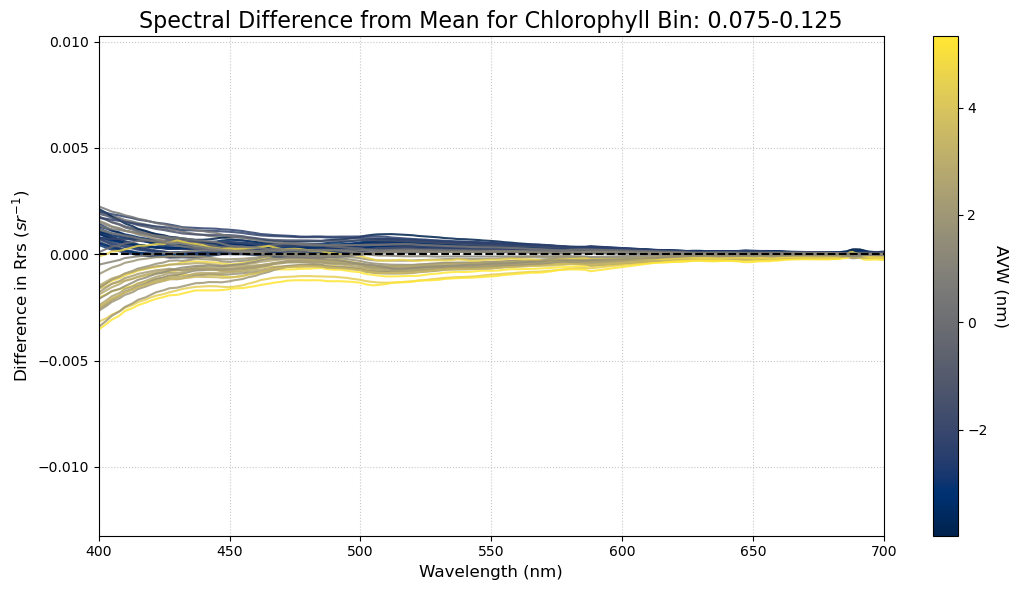

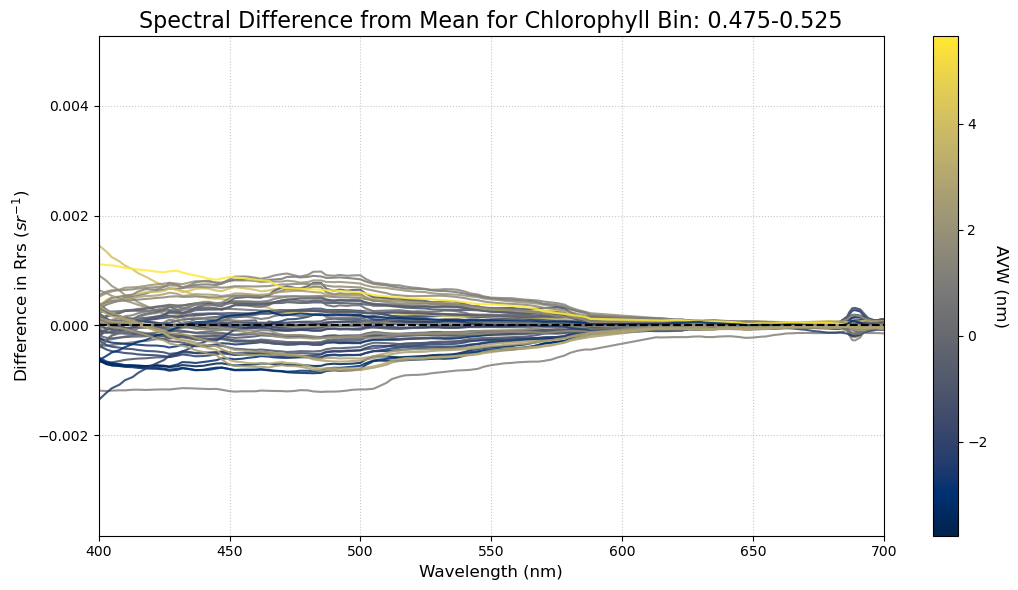

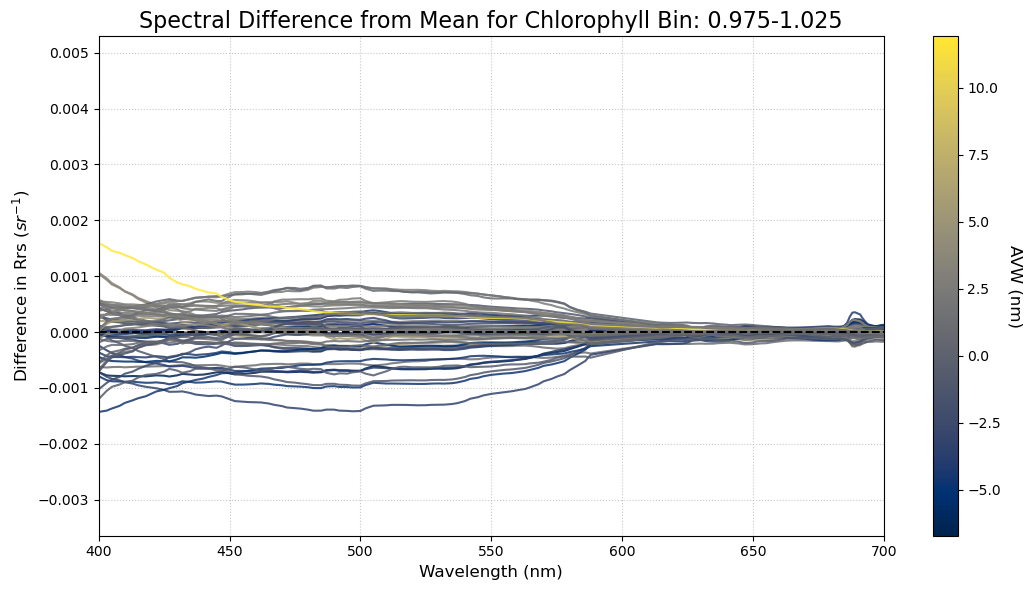

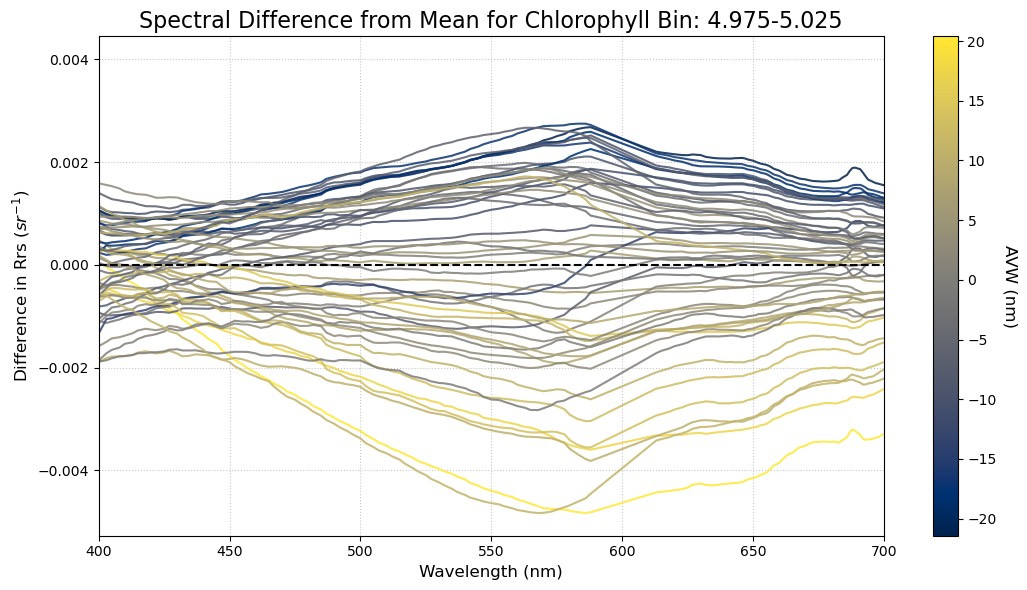

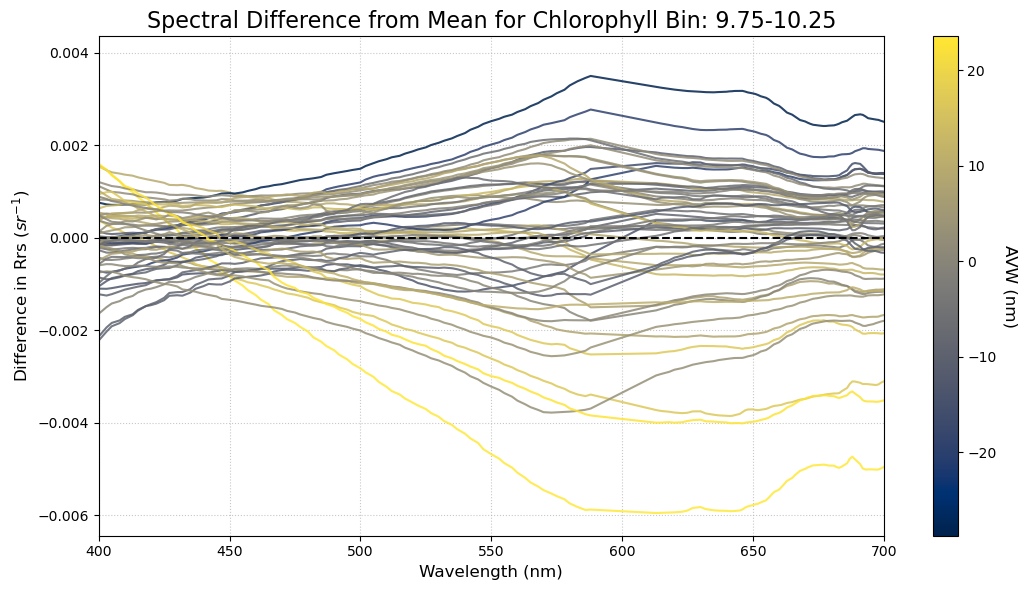

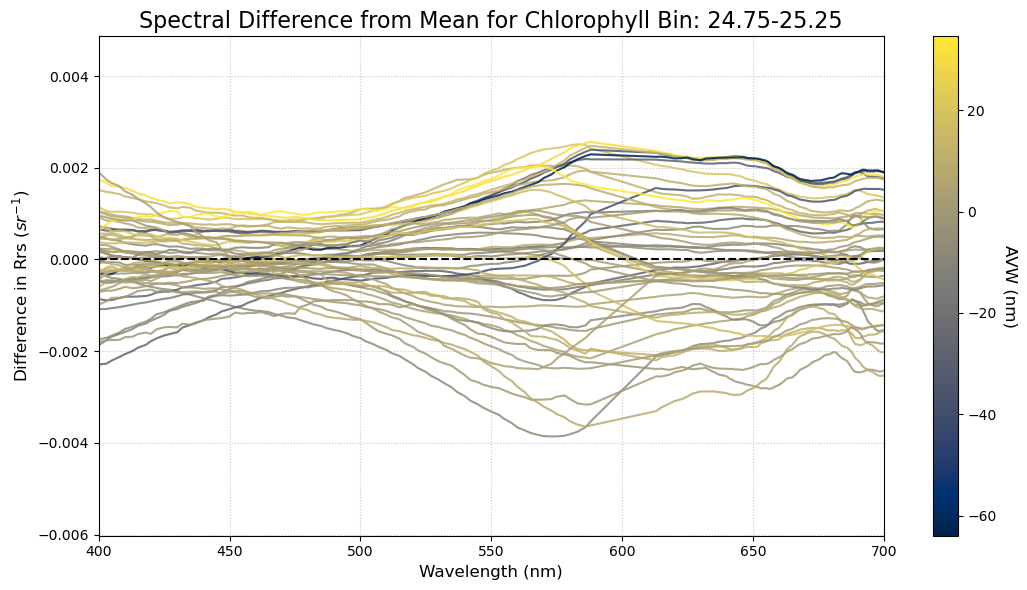

In [21]:
plot_diff_spectra_by_avw(results, overall_mean_spectra, wavelengths_full)


Generating time-series plots...


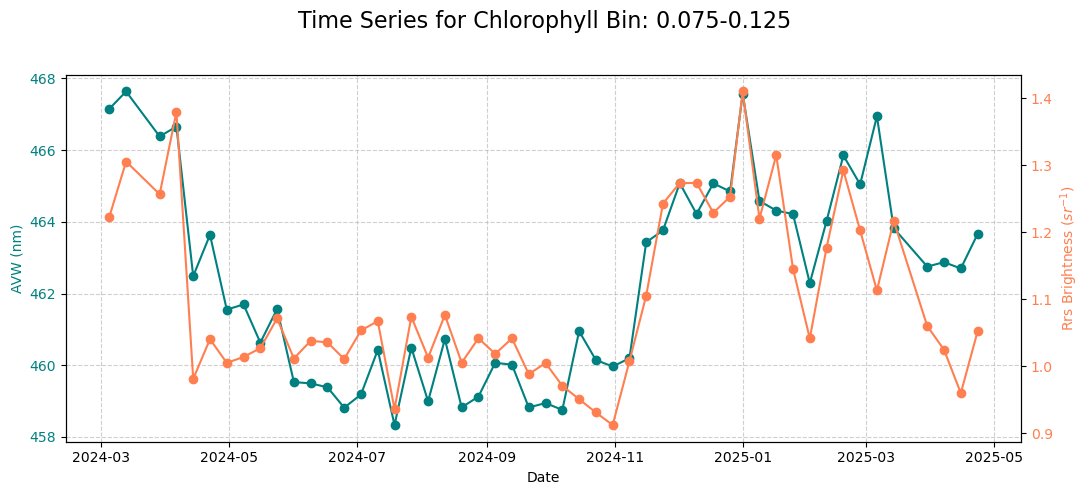

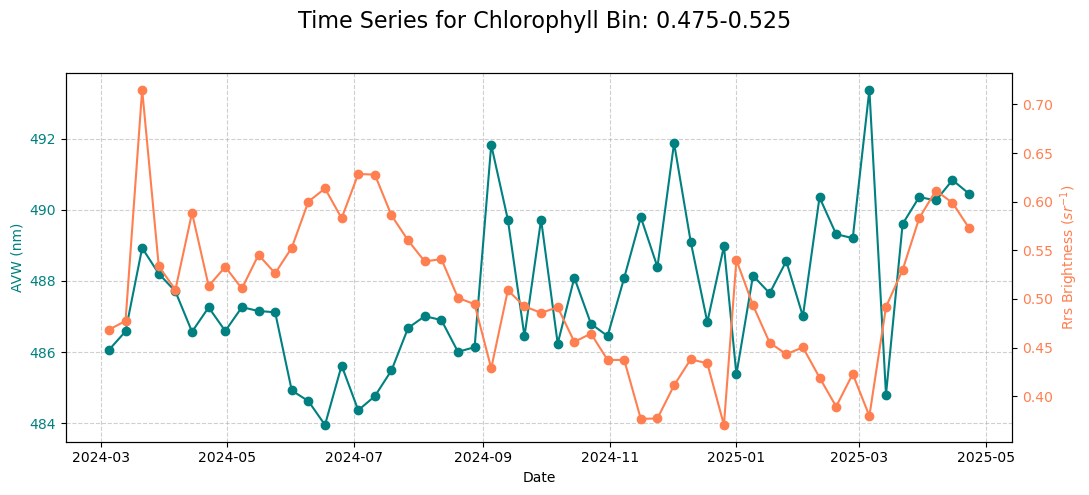

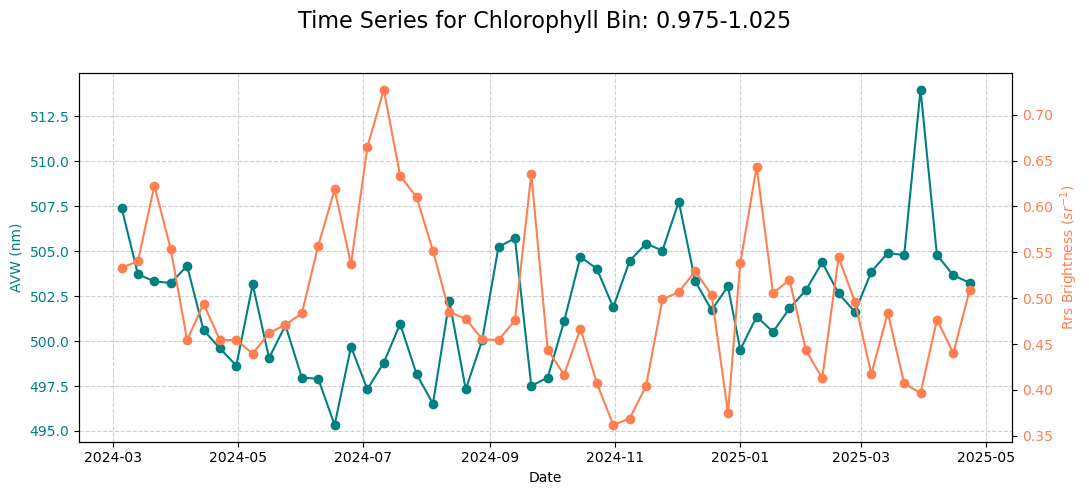

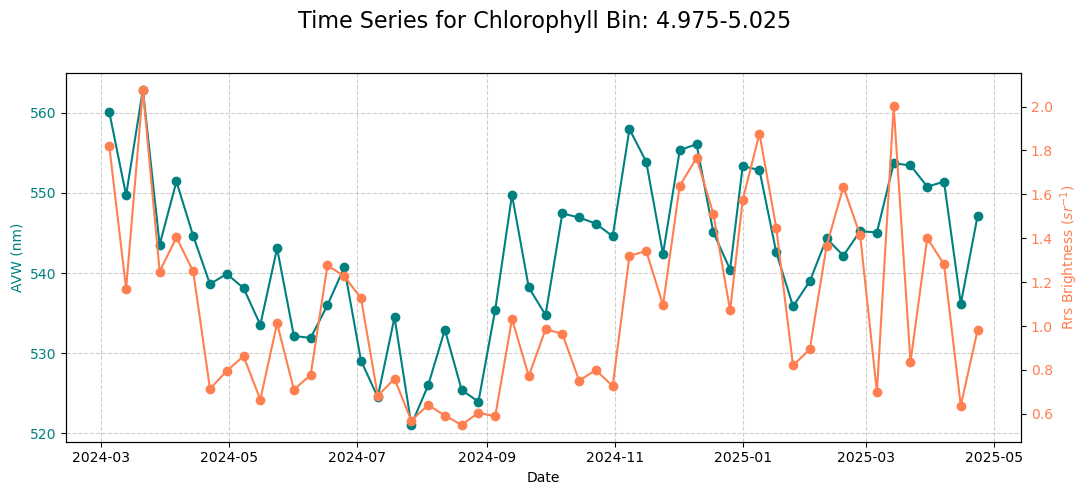

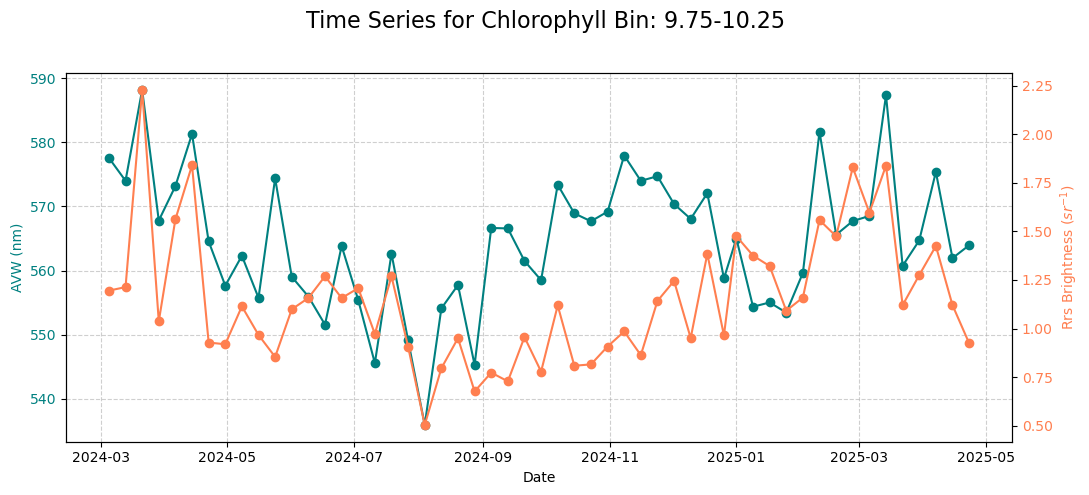

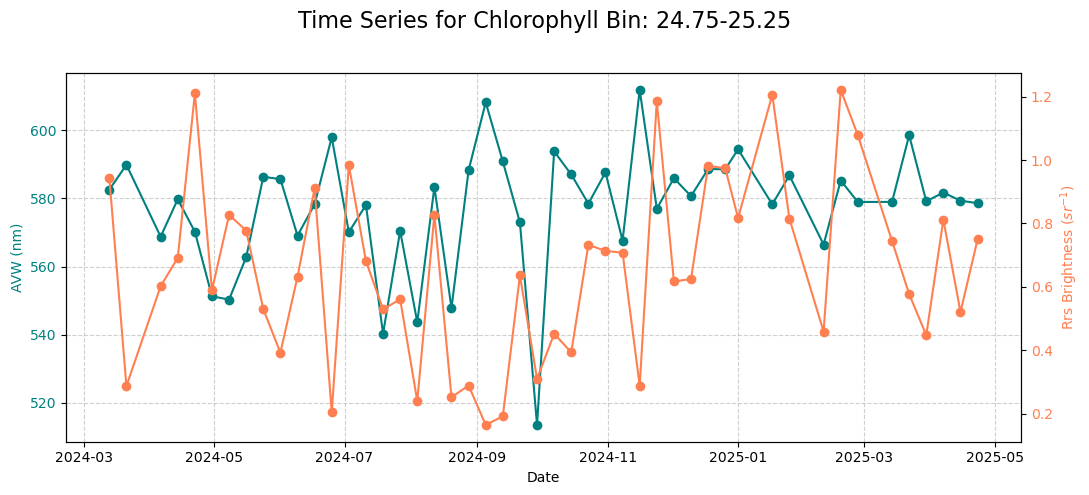

In [5]:
plot_time_series(results)



### How to Plot a Specific Spectrum by Index ###
Plotting index 15 (Date: 2024-07-03) for Bin 5 ('9.75-10.25')...


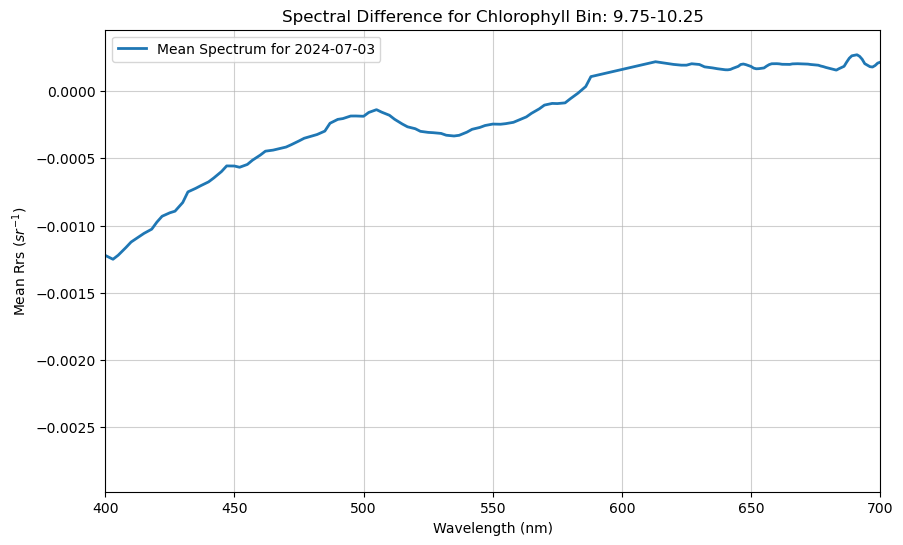

In [8]:
#  '0.075-0.125'
#  '0.475-0.525'
#  '0.975-1.025'
#  '4.975-5.025'
#  '9.75-10.25'
#  '24.75-25.25'

# --- Use this block to choose and plot a specific spectrum by INDEX ---
print("\n### How to Plot a Specific Spectrum by Index ###")

# 1. Look at the 'Data Summary' above to see which bins have data.
# 2. Choose the INDEX of the bin you want to plot (0-6).
selected_bin_index = 5  # 0 is the first bin, 1 is the second, etc.

# 3. Choose the index of the dot on that bin's plot (0=first, 1=second, etc.)
selected_index_for_plot = 15

# --- This code will use your selections to make the plot ---

# Get the corresponding string label from the index
selected_bin_label = bins_labels[selected_bin_index]

if selected_bin_label in results and selected_index_for_plot < len(results[selected_bin_label]['dates']):
    date_obj = results[selected_bin_label]['dates'][selected_index_for_plot]
    print(f"Plotting index {selected_index_for_plot} (Date: {date_obj.strftime('%Y-%m-%d')}) for Bin {selected_bin_index} ('{selected_bin_label}')...")
    plot_spectral_comparison(date_obj.strftime('%Y-%m-%d'), selected_bin_label)
else:
    print(f"\nError: Could not generate spectral plot for Bin {selected_bin_index}.")
    print("Please check the 'Data Summary' to ensure this bin has valid time steps and the plot index is in range.")
